# Kaplan-Meier Survivorship Cockroach Project - Lab Data

Read in the BG_lab_contact csv file into a pandas dataframe. The data documents the time of death ('Hours' since start of experiment) of each cockroach, the 'Treatment' group to which it belonged, the subject 'ID,' and 'Censor' value (1 = death, 0 = alive at end of experiment). The experiment tests the activity of an insecticial bait on cockroaches when it is ingested compared to when it only contacts the cockroach's body.

In [68]:
import pandas as pd
BG_contact = pd.read_csv('/Users/Yvonne/Desktop/Zyrox_Py/BG_lab_contact_YKM.csv')
BG_contact.head()

,ID,Hours,Treatment,Censor
0,1,2,BG_Z_i25,1
1,2,2,BG_Z_i25,1
2,3,2,BG_Z_i25,1
3,4,2,BG_Z_i25,1
4,5,2,BG_Z_i25,1


Now let's look at an example graph of this data that we want to replicate using Python. We will be analyzing the data with Kaplan-Meier survivorship curves, and are choosing this option over regression due to the presence of censored responses (0's in the 'Censor' column).

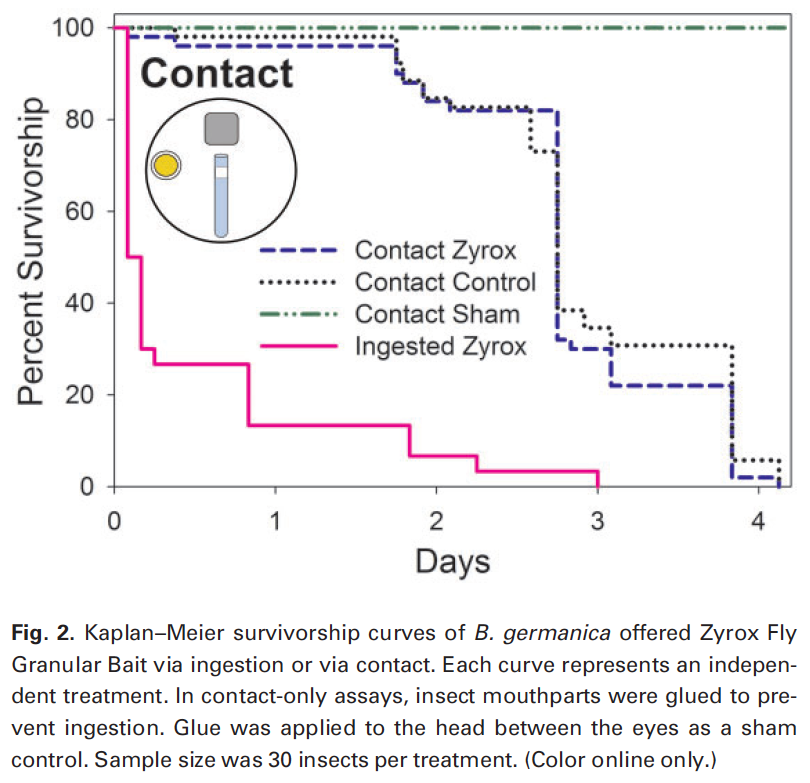

In [92]:
from IPython.display import Image, display
Image('/Users/Yvonne/Desktop/Zyrox_Py/Contact.png')

Our dataframe is already in the right format for lifelines (Python package we will use for analysis), but we'll still need to do a bit of preprocessing. Let's take a look at an example from the lifelines documentation to see what we need to do.

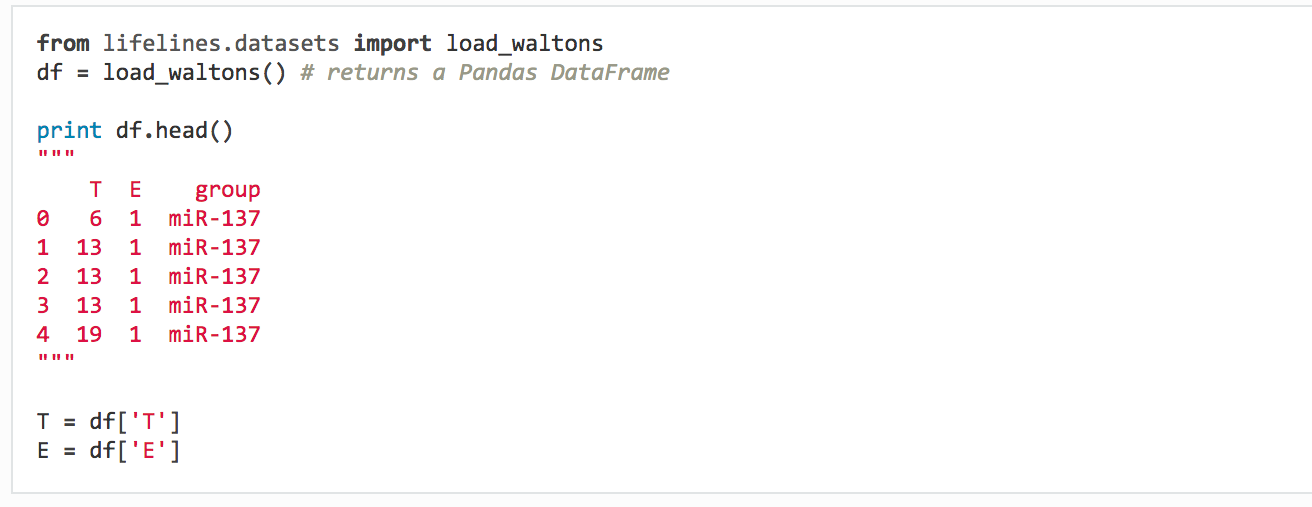

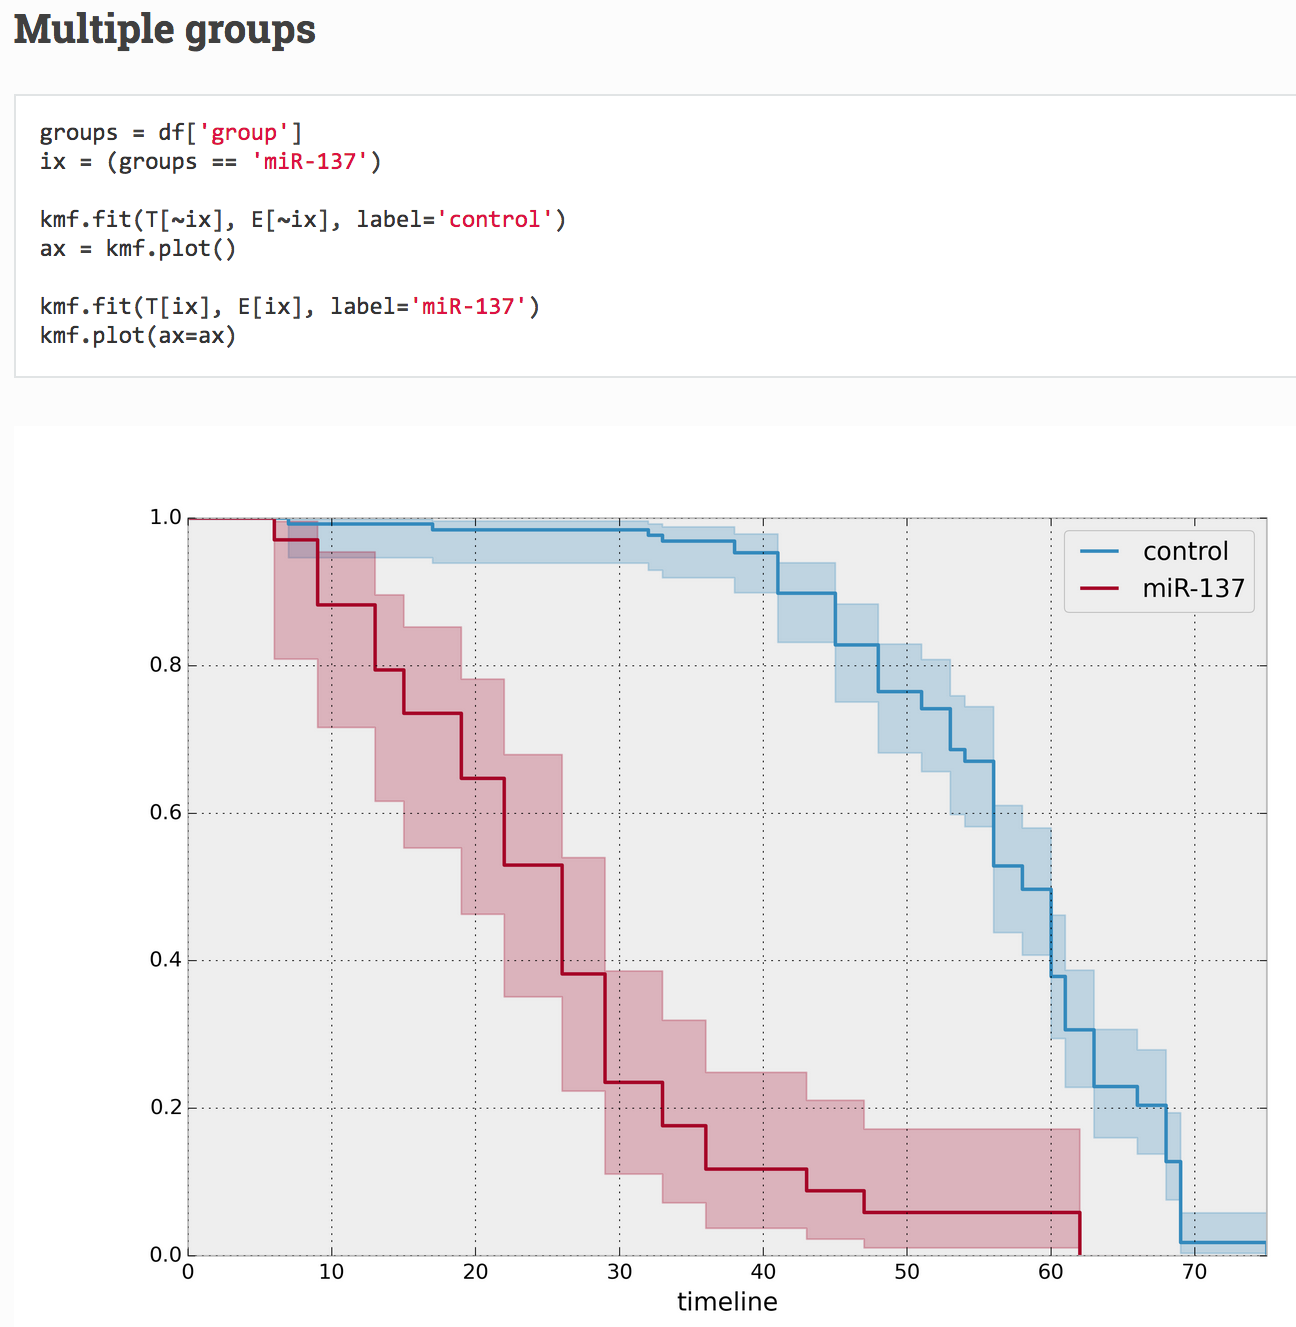

In [94]:
x = Image('/Users/Yvonne/Desktop/Zyrox_Py/KM_setup.png') 
y = Image('/Users/Yvonne/Desktop/Zyrox_Py/KM_docs.png') 
display(x, y)

In the Kaplan-Meier example avove, they create variables for the time ('T'), censor ('E'), and treatment ('group') columns, and also for each group in the 'groups' variable. We'll do the same for our data.

In [19]:
T = (BG_contact['Hours'])/24  # Express time in days instead of hours
E = BG_contact['Censor']
groups = BG_contact['Treatment']
a = (groups == 'BG_Z_i25')
z = (groups == 'Z_rcon')
c = (groups == 'C_rcon')

Let's fit our data to the KaplanMeierFitter following the example from documentation.

(Note: iterating through kmf.fit returns an error and prevents you from assigning a label, so in this case it is necessary to run the code separately for each plot.)

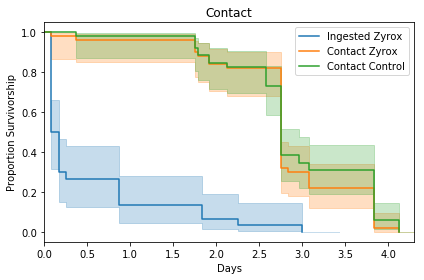

In [20]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
%matplotlib inline

kmf = KaplanMeierFitter()

kmf.fit(T[a], E[a], label='Ingested Zyrox')
ax = kmf.plot()

kmf.fit(T[z], E[z], label='Contact Zyrox')
kmf.plot(ax=ax)

kmf.fit(T[c], E[c], label='Contact Control')
kmf.plot(ax=ax)

# plt.style('whitegrid')
plt.title('Contact')
plt.xlabel('Days')
plt.ylabel('Proportion Survivorship')
plt.xlim(0, 4.3)
plt.tight_layout()

Great! We've now replicted our example graph. Now it's time to run statistics on the results. First, we'll run a multivariate log rank test on the dataframe to see if there are overall differences among the curves.

In [40]:
from lifelines.statistics import multivariate_logrank_test
multivariate_logrank_test(event_durations=T, groups=groups, event_observed=E, alpha=0.99, bonferroni=True)

<lifelines.StatisticalResult: 
Results
   t 0: -1
   test: logrank
   alpha: 0.99
   null distribution: chi squared
   df: 5
   bonferroni: True

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            337.454 |      Reject Null    |        True       
>

We can see that overall there are differences among the curves since the P-value is highly significant (P < 0.0001).

Now let's look further and do a pairwise log rank test to compare individual curves to one another. (You may need to run pd.set_option('display.max_colwidth', -1) in order to view the results in a Jupyter notebook).

In [69]:
from lifelines.statistics import pairwise_logrank_test
results = pairwise_logrank_test(event_durations=T, groups=groups, event_observed=E, alpha=0.95, bonferroni=True)
pd.set_option('display.max_colwidth', -1)
results


,BG_Z_i25,C_rcon,Z_rcon
BG_Z_i25,None,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.9833333333333333\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: BG_Z_i25 vs. C_rcon\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 77.403 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.9833333333333333\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: BG_Z_i25 vs. Z_rcon\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 72.706 | Reject Null | True \n>
C_rcon,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.9833333333333333\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: BG_Z_i25 vs. C_rcon\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 77.403 | Reject Null | True \n>,None,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.9833333333333333\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_rcon vs. Z_rcon\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.56702 | 0.328 | Cannot Reject Null | False \n>
Z_rcon,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.9833333333333333\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: BG_Z_i25 vs. Z_rcon\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 72.706 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.9833333333333333\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_rcon vs. Z_rcon\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.56702 | 0.328 | Cannot Reject Null | False \n>,None


The results show that ingested bait ('BG_Z_i25') killed cockroaches faster (see graph) than both contacted bait ('Z_rcon') and the control ('C_rcon'). However, there is no difference between the contacted bait and control, which leads us to conclude the bait is kills via ingestion only, and not when it contacts the cockroach's body.

Now let's analyze two additional datasets in this study. Below is the graph we'd like to replicate using Python.

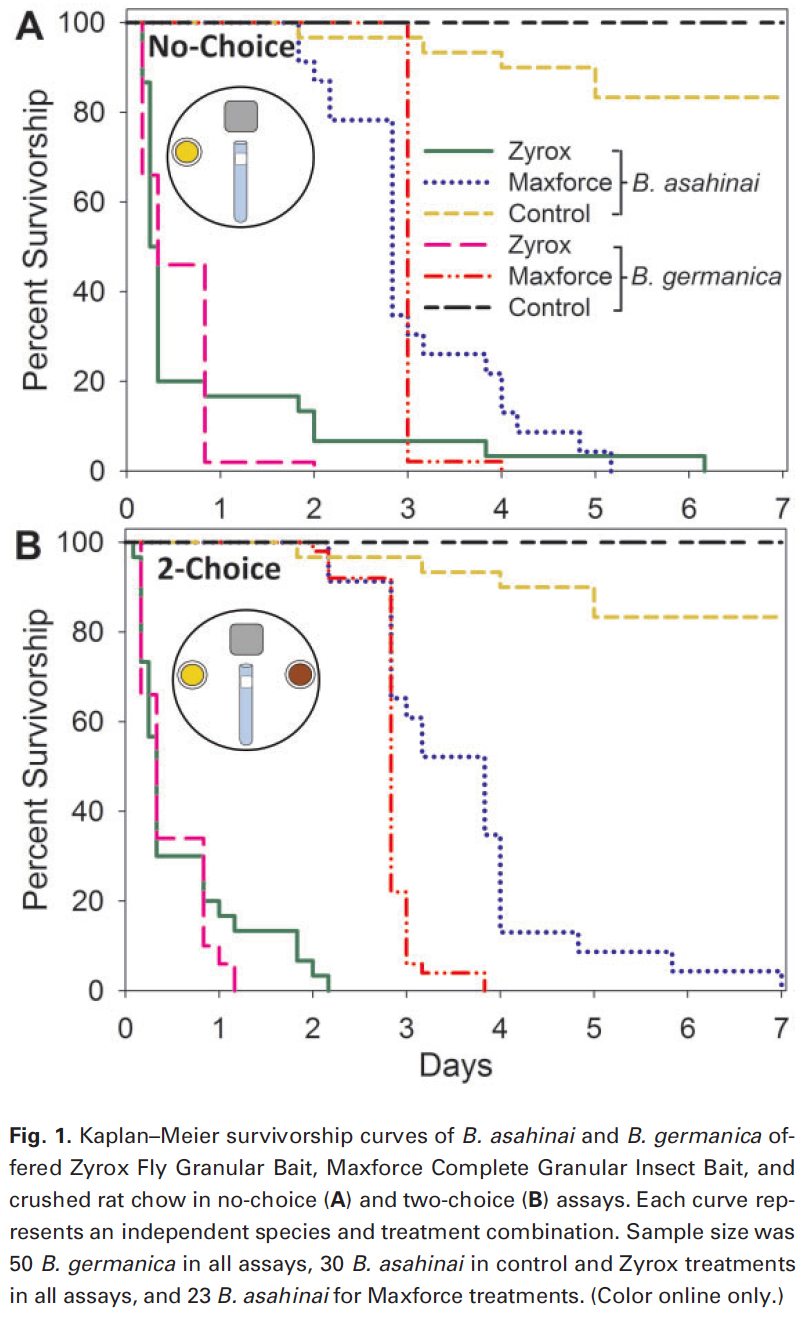

In [21]:
Image('/Users/Yvonne/Desktop/Zyrox_Py/NoCh_2Ch.png')

Read in the No_choice csv file into a pandas dataframe. The data and columns are structured the same way as in the BG_contact dataframe. This experiment, however, tests two types of insecticidal baits and normal food as a control against two different species of pest cockroach ('BA' and BG'). Cockroaches were given only bait or only normal food.

In [67]:
No_Choice = pd.read_csv('/Users/Yvonne/Desktop/Zyrox_Py/Zyrox_Lab_NoChoice_YKM.csv')
No_Choice.head()

,ID,Hours,Treatment,Censor
0,1,4,Z_BGnc,1
1,2,4,Z_BGnc,1
2,3,4,Z_BGnc,1
3,4,4,Z_BGnc,1
4,5,4,Z_BGnc,1


We'll follow the same steps as we did above for this No_Choice dataframe.

In [31]:
# Display the names of groups in the 'Treatment' column.
No_Choice.groupby('Treatment').groups

{'C_BAn2c': Int64Index([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
             163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
             176, 177, 178, 179],
            dtype='int64'),
 'C_BGnc': Int64Index([180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
             193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
             206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
             219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229],
            dtype='int64'),
 'M_BAnc': Int64Index([127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
             140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
            dtype='int64'),
 'M_BGnc': Int64Index([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
             67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
             84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
            

In [35]:
T = (No_Choice['Hours'])/24  # Express time in days instead of hours
E = No_Choice['Censor']
groups = No_Choice['Treatment']
c_ba = (groups == 'C_BAn2c')
c_bg = (groups == 'C_BGnc')
m_ba = (groups == 'M_BAnc')
m_bg = (groups == 'M_BGnc')
z_ba = (groups == 'Z_BAnc')
z_bg = (groups == 'Z_BGnc')

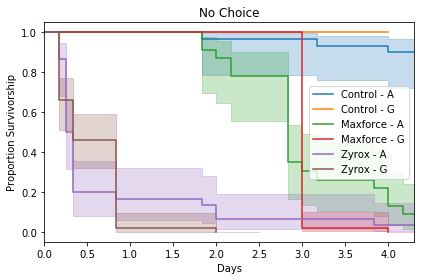

In [38]:
kmf = KaplanMeierFitter()

kmf.fit(T[c_ba], E[c_ba], label='Control - A')
ax = kmf.plot()

kmf.fit(T[c_bg], E[c_bg], label='Control - G')
kmf.plot(ax=ax)

kmf.fit(T[m_ba], E[m_ba], label='Maxforce - A')
kmf.plot(ax=ax)

kmf.fit(T[m_bg], E[m_bg], label='Maxforce - G')
kmf.plot(ax=ax)

kmf.fit(T[z_ba], E[z_ba], label='Zyrox - A')
kmf.plot(ax=ax)

kmf.fit(T[z_bg], E[z_bg], label='Zyrox - G')
kmf.plot(ax=ax)

# plt.style('whitegrid')
plt.title('No Choice')
plt.xlabel('Days')
plt.ylabel('Proportion Survivorship')
plt.xlim(0, 4.3)
plt.tight_layout()

In [41]:
multivariate_logrank_test(event_durations=T, groups=groups, event_observed=E, alpha=0.99, bonferroni=True)

<lifelines.StatisticalResult: 
Results
   t 0: -1
   test: logrank
   alpha: 0.99
   null distribution: chi squared
   df: 5
   bonferroni: True

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            337.454 |      Reject Null    |        True       
>

In [95]:
from lifelines.statistics import pairwise_logrank_test
results = pairwise_logrank_test(event_durations=T, groups=groups, event_observed=E, alpha=0.95, bonferroni=True)
pd.set_option('display.max_colwidth', -1)
results

,C_BAn2c,M_BA2c,M_BG2c,Z_BA2c,Z_BG2c
C_BAn2c,None,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. M_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 45.884 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. M_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 72.350 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. Z_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 67.856 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. Z_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 77.550 | Reject Null | True \n>
M_BA2c,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. M_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 45.884 | Reject Null | True \n>,None,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BA2c vs. M_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 22.425 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BA2c vs. Z_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 55.461 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BA2c vs. Z_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 64.122 | Reject Null | True \n>
M_BG2c,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. M_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 72.350 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BA2c vs. M_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 22.425 | Reject Null | True \n>,None,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BG2c vs. Z_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 103.143 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BG2c vs. Z_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 113.157 | Reject Null | True \n>
Z_BA2c,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. Z_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 67.

We can see from these results that Zyrox bait killed both species of cockroaches significantly faster than Maxforce bait (see graph). Cockroaches of both species died more quickly when offered both types of bait than when offered normal food control. From these results we can conclude that both Zyrox and Maxforce baits effectively kill both species of cockroach, but Zyrox kills faster than Maxforce.

There is one more dataset to analyze - read the Two_choice csv file into a pandas dataframe. The data and columns are structured the same way as in the BG_contact and No_Choice dataframes. This experiment has the exact setup as the No_choice experiment with one key difference - cockroaches were offered a choice between bait and normal food.

In [43]:
Two_Choice = pd.read_csv('/Users/Yvonne/Desktop/Zyrox_Py/Zyrox_Lab_2Choice_YKM.csv')
Two_Choice.head()

,ID,Hours,Treatment,Event
0,1,4,Z_BG2c,1
1,2,4,Z_BG2c,1
2,3,4,Z_BG2c,1
3,4,4,Z_BG2c,1
4,5,4,Z_BG2c,1


We will follow the same analysis steps as in the previous two dataframes.

In [45]:
Two_Choice.groupby('Treatment').groups

{'C_BAn2c': Int64Index([153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
             166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
             179, 180, 181, 182],
            dtype='int64'),
 'M_BA2c': Int64Index([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
             143, 144, 145, 146, 147, 148, 149, 150, 151, 152],
            dtype='int64'),
 'M_BG2c': Int64Index([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
             67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
             84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
            dtype='int64'),
 'Z_BA2c': Int64Index([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
             113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
             126, 127, 128, 129],
            dtype='int64'),
 'Z_BG2c': Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15

In [47]:
T = (Two_Choice['Hours'])/24  # Express time in days instead of hours
E = Two_Choice['Event']
groups = Two_Choice['Treatment']
c_ba = (groups == 'C_BAn2c')
m_2ba = (groups == 'M_BA2c')
m_2bg = (groups == 'M_BG2c')
z_2ba = (groups == 'Z_BA2c')
z_2bg = (groups == 'Z_BG2c')

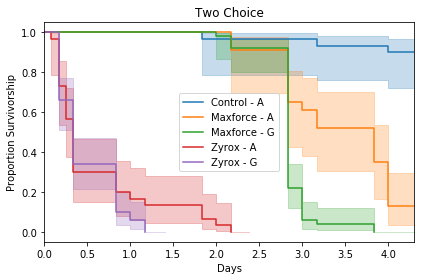

In [48]:
kmf = KaplanMeierFitter()

kmf.fit(T[c_ba], E[c_ba], label='Control - A')
ax = kmf.plot()

kmf.fit(T[m_2ba], E[m_2ba], label='Maxforce - A')
kmf.plot(ax=ax)

kmf.fit(T[m_2bg], E[m_2bg], label='Maxforce - G')
kmf.plot(ax=ax)

kmf.fit(T[z_2ba], E[z_2ba], label='Zyrox - A')
kmf.plot(ax=ax)

kmf.fit(T[z_2bg], E[z_2bg], label='Zyrox - G')
kmf.plot(ax=ax)

# plt.style('whitegrid')
plt.title('Two Choice')
plt.xlabel('Days')
plt.ylabel('Proportion Survivorship')
plt.xlim(0, 4.3)
plt.tight_layout()

In [49]:
multivariate_logrank_test(event_durations=T, groups=groups, event_observed=E, alpha=0.99, bonferroni=True)

<lifelines.StatisticalResult: 
Results
   t 0: -1
   test: logrank
   alpha: 0.99
   null distribution: chi squared
   df: 4
   bonferroni: True

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            269.353 |      Reject Null    |        True       
>

In [85]:
results = pairwise_logrank_test(event_durations=T, groups=groups, event_observed=E, alpha=0.95, bonferroni=True)
results

,C_BAn2c,M_BA2c,M_BG2c,Z_BA2c,Z_BG2c
C_BAn2c,None,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. M_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 45.884 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. M_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 72.350 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. Z_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 67.856 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. Z_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 77.550 | Reject Null | True \n>
M_BA2c,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. M_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 45.884 | Reject Null | True \n>,None,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BA2c vs. M_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 22.425 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BA2c vs. Z_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 55.461 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BA2c vs. Z_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 64.122 | Reject Null | True \n>
M_BG2c,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. M_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 72.350 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BA2c vs. M_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 22.425 | Reject Null | True \n>,None,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BG2c vs. Z_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 103.143 | Reject Null | True \n>,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: M_BG2c vs. Z_BG2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 113.157 | Reject Null | True \n>
Z_BA2c,<lifelines.StatisticalResult: \nResults\n t 0: -1\n test: logrank\n alpha: 0.995\n null distribution: chi squared\n df: 1\n use bonferroni: True\n test name: C_BAn2c vs. Z_BA2c\n\n __ p-value ___|__ test statistic __|____ test result ____|__ is significant __\n 0.00000 | 67.

These results are very similar to results from the No_Choice experiment - both baits killed both species of cockroach, and Zyrox bait killed faster than Maxforce bait. We can conclude that despite being given a choice of normal food, the cockroaches still ate the bait. The bait is therefore attractive and palatable to cockroaches.